# Processing text queries
- code in this notebook predominantly analyze text queries submitted by participants to solve KIS tasks of VBS 2023
- among others, this notebook can replicate the content of Table 4 as well as Figures 10-12
- it is assumed that pre-processed query events of individual teams are already generated and stored in data/processed/kis-logs/[TeamName]_events.csv

In [1]:
import sys
import os
modules_path = os.getcwd() + '/..'
sys.path.insert(0, modules_path)

# imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
from notebooks.utils import compute_user_penalty, get_team_values_df
from common.load import load_competition_data, process_team_logs

pd.set_option('display.max_colwidth', None)
unknownRankLimit = 1000
unknownRankValue = 2000

# Import common data

In [2]:
config = modules_path +'/config_vbs2023.yaml'

# load competition data from dres files and auxiliary data (FPSs, sequences)
comp_data = load_competition_data(config)

# compute team logs and put them in the form of dataframes (or load them if already existing)
logs = process_team_logs(config, comp_data, force=False)

teams = comp_data['config']['teams']
teams.remove('VideoCLIP')

# FIXME: badly patch the name of HTW into vibro
teams_adj = teams.copy()
teams_adj = [t if t != 'HTW' else 'vibro' for t in teams_adj]

# valid teams
team_order = ['vibro', 'VISIONE', 'vitrivr-VR', 'CVHunter',  'Verge']

c:\Lang\Python\VBS23-Post-Hoc-Analysis\src\python\notebooks/..\common\tasks.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.tasks_df = self.tasks_df.append({
c:\Lang\Python\VBS23-Post-Hoc-Analysis\src\python\notebooks/..\common\tasks.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.tasks_df = self.tasks_df.append({
c:\Lang\Python\VBS23-Post-Hoc-Analysis\src\python\notebooks/..\common\tasks.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.tasks_df = self.tasks_df.append({
c:\Lang\Python\VBS23-Post-Hoc-Analysis\src\python\notebooks/..\common\tasks.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.tasks_

# Merge team data into one dataframe

In [3]:
teams

['HTW', 'VISIONE', 'VIREO', 'vitrivr-VR', 'CVHunter', 'vitrivr', 'Verge']

In [4]:
dfs = []
for team in teams:
    team_df = logs[team].get_events_dataframe().reset_index()
    dfs.append(team_df)

dataset = pd.concat(dfs, axis=0).reset_index()
dataset.head()

,level_0,index,task,team,user,timestamp,elapsed_since_task_start_ms,correct_submission_time_ms,rank_video,rank_shot_margin_0,rank_shot_margin_5,max_rank,category,type,value,additionals,is_user_with_correct_submission
0,0,0,vbs23-kis-v1,HTW,0,1673259650000,36687,43981.0,1.0,1.0,1.0,10000.0,TEXT,jointEmbedding,Man in pink closest standing a basketball stadium,{},NaN
1,1,1,vbs23-kis-t1,HTW,0,1673260401000,28139,36751.0,1.0,1.0,1.0,10000.0,TEXT,jointEmbedding,"Kids in kayaks on a river, throwing paddles through three coloured hoops placed over the water.",{},NaN
2,2,2,vbs23-kis-t2,HTW,0,1673260903000,6356,26109.0,1.0,1.0,1.0,10000.0,TEXT,jointEmbedding,Hands of a kid applying glue to an egg carton and then a view of a sculpture made of those cartons.,{},NaN
3,3,3,vbs23-kis-t3,HTW,0,1673261414000,12701,394938.0,670.0,670.0,670.0,10000.0,TEXT,jointEmbedding,A view through the glass roof of a lift cabin while it is moving upwards.,{},NaN
4,4,4,vbs23-kis-t3,HTW,0,1673261434000,32701,394938.0,75.0,75.0,75.0,10000.0,IMAGE,globalFeatures,video 14479 at 00:08:18.500 (Frame #12462),{},NaN


# Data checks

In [5]:
dataset.is_user_with_correct_submission.unique()

array([nan,  0.,  1.])

In [6]:
dataset.category.unique()

array(['TEXT', 'IMAGE', 'TEMPORAL', nan, 'mlclip',
       'visualtextcoembedding', 'BROWSING', 'SUBMIT', 'SKETCH', 'FILTER'],
      dtype=object)

In [7]:
dataset.groupby("team")["task"].nunique()

team
CVHunter      19
HTW           19
VIREO         19
VISIONE       19
Verge         16
vitrivr       19
vitrivr-VR    16
Name: task, dtype: int64

### vitrivr sketch

In [8]:
dataset.loc[dataset.category == "SKETCH"]

,level_0,index,task,team,user,timestamp,elapsed_since_task_start_ms,correct_submission_time_ms,rank_video,rank_shot_margin_0,rank_shot_margin_5,max_rank,category,type,value,additionals,is_user_with_correct_submission
1409,44,44,vbs23-kis-v-m4,vitrivr,0,1673272491103,117918,NaN,8649.0,8649.0,8649.0,10000.0,SKETCH,NaN,color,{},NaN


### vitrivr value column

In [9]:
dataset.loc[dataset.team == "vitrivr"]

,level_0,index,task,team,user,timestamp,elapsed_since_task_start_ms,correct_submission_time_ms,rank_video,rank_shot_margin_0,rank_shot_margin_5,max_rank,category,type,value,additionals,is_user_with_correct_submission
1365,0,0,vbs23-kis-v1,vitrivr,0,1673259630775,17462,68132.0,inf,inf,inf,4990.0,TEXT,NaN,NaN,{},NaN
1366,1,1,vbs23-kis-t1,vitrivr,0,1673260395711,22850,93575.0,3.0,4.0,4.0,4981.0,TEXT,NaN,NaN,{},NaN
1367,2,2,vbs23-kis-t1,vitrivr,0,1673260461824,88963,93575.0,10.0,10.0,10.0,4988.0,TEXT,NaN,NaN,{},NaN
1368,3,3,vbs23-kis-t2,vitrivr,0,1673260917544,20900,218530.0,200.0,200.0,200.0,4991.0,TEXT,NaN,NaN,{},NaN
1369,4,4,vbs23-kis-t2,vitrivr,0,1673260989249,92605,218530.0,71.0,71.0,71.0,4991.0,TEXT,NaN,NaN,{},NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1479,114,114,vbs23-kis-v5,vitrivr,1,1673278598476,52235,NaN,242.0,2816.0,2816.0,9950.0,TEXT,NaN,NaN,{},NaN
1480,115,115,vbs23-kis-v5,vitrivr,1,1673278614088,67847,NaN,242.0,2816.0,2816.0,9950.0,TEXT,NaN,NaN,{},NaN
1481,116,116,vbs23-kis-v5,vitrivr,1,1673278671514,125273,NaN,40.0,1167.0,1167.0,4981.0,TEXT,NaN,NaN,{},NaN
1482,117,117,vbs23-kis-v5,vitrivr,1,1673278736822,190581,NaN,23.0,739.0,739.0,4986.0,TEXT,NaN,NaN,{},NaN


### vitrivr-VR visualtextcoembedding

In [10]:
dataset.loc[dataset.category == "visualtextcoembedding"]

,level_0,index,task,team,user,timestamp,elapsed_since_task_start_ms,correct_submission_time_ms,rank_video,rank_shot_margin_0,rank_shot_margin_5,max_rank,category,type,value,additionals,is_user_with_correct_submission
644,1,1,vbs23-kis-v1,vitrivr-VR,0,1673259676512,68199,171058.0,4441.0,inf,inf,NaN,visualtextcoembedding,TEXT,man in a sports hall doing a backflip,NaN,NaN


### VIREO types and category

In [11]:
dataset.loc[dataset.team == "VIREO"]

,level_0,index,task,team,user,timestamp,elapsed_since_task_start_ms,correct_submission_time_ms,rank_video,rank_shot_margin_0,rank_shot_margin_5,max_rank,category,type,value,additionals,is_user_with_correct_submission
407,0,0,vbs23-kis-v1,VIREO,0,1673259634037,20724,48547.0,794.0,inf,inf,1000.0,NaN,NaN,NaN,NaN,NaN
408,1,1,vbs23-kis-v1,VIREO,0,1673259636735,23422,48547.0,300.0,inf,inf,1000.0,NaN,NaN,NaN,NaN,NaN
409,2,2,vbs23-kis-v1,VIREO,0,1673259649218,35905,48547.0,260.0,inf,inf,1000.0,NaN,NaN,NaN,NaN,NaN
410,3,3,vbs23-kis-t1,VIREO,0,1673260405338,32477,166258.0,inf,inf,inf,1000.0,NaN,NaN,NaN,NaN,NaN
411,4,4,vbs23-kis-t1,VIREO,0,1673260449743,76882,166258.0,inf,inf,inf,1000.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
638,231,231,vbs23-kis-v4,VIREO,1,1673277200248,23035,45771.0,163.0,inf,inf,1000.0,NaN,NaN,NaN,NaN,NaN
639,232,232,vbs23-kis-v4,VIREO,1,1673277208737,31524,45771.0,141.0,141.0,141.0,1000.0,NaN,NaN,NaN,NaN,NaN
640,233,233,vbs23-kis-t7,VIREO,1,1673277558871,27337,191328.0,6.0,inf,6.0,1000.0,NaN,NaN,NaN,NaN,NaN
641,234,234,vbs23-kis-t7,VIREO,1,1673277697834,166300,191328.0,5.0,inf,5.0,1000.0,NaN,NaN,NaN,NaN,NaN


### vitrivr-VR types and category

In [12]:
dataset.loc[dataset.team == "vitrivr-VR"].head()

,level_0,index,task,team,user,timestamp,elapsed_since_task_start_ms,correct_submission_time_ms,rank_video,rank_shot_margin_0,rank_shot_margin_5,max_rank,category,type,value,additionals,is_user_with_correct_submission
643,0,0,vbs23-kis-v1,vitrivr-VR,0,1673259638599,30286,171058.0,inf,inf,inf,NaN,mlclip,TEXT,man in a sports hall doing a backflip,NaN,NaN
644,1,1,vbs23-kis-v1,vitrivr-VR,0,1673259676512,68199,171058.0,4441.0,inf,inf,NaN,visualtextcoembedding,TEXT,man in a sports hall doing a backflip,NaN,NaN
645,2,2,vbs23-kis-v1,vitrivr-VR,1,1673259678971,70658,171058.0,inf,inf,inf,NaN,mlclip,TEXT,man in blue shirt doing backflip,NaN,NaN
646,3,3,vbs23-kis-v1,vitrivr-VR,0,1673259716531,108218,171058.0,74.0,834.0,834.0,NaN,mlclip,TEXT,man wearing american flag in a sports hall doing a backflip,NaN,NaN
647,4,4,vbs23-kis-v1,vitrivr-VR,0,1673259745302,136989,171058.0,62.0,189.0,189.0,NaN,mlclip,TEXT,a man in a white shirt and blue pants dancing in a sports hall,NaN,NaN


### verge filter

In [13]:
dataset.loc[dataset.category == "FILTER"]

,level_0,index,task,team,user,timestamp,elapsed_since_task_start_ms,correct_submission_time_ms,rank_video,rank_shot_margin_0,rank_shot_margin_5,max_rank,category,type,value,additionals,is_user_with_correct_submission
1589,105,105,vbs23-kis-t6,Verge,0,1673264294471,131097,179991.0,3.0,3.0,3.0,232.0,FILTER,numberOfObjects,2,{},NaN


### verge concept

In [14]:
dataset.loc[((dataset.team == "Verge") & (dataset.type=="concept"))].head()

,level_0,index,task,team,user,timestamp,elapsed_since_task_start_ms,correct_submission_time_ms,rank_video,rank_shot_margin_0,rank_shot_margin_5,max_rank,category,type,value,additionals,is_user_with_correct_submission
1496,12,12,vbs23-kis-v1,Verge,0,1673259819531,206218,221930.0,inf,inf,inf,2691.0,TEXT,concept,",,",{},NaN
1507,23,23,vbs23-kis-t1,Verge,0,1673260586873,214012,281491.0,inf,inf,inf,10000.0,TEXT,concept,NaN,{},NaN
1509,25,25,vbs23-kis-t1,Verge,0,1673260597146,224285,281491.0,inf,inf,inf,262.0,TEXT,concept,",",{},NaN
1527,43,43,vbs23-kis-t2,Verge,0,1673261206262,309618,NaN,inf,inf,inf,1174.0,TEXT,concept,",",{},NaN
1580,96,96,vbs23-kis-t5,Verge,0,1673263133819,307207,NaN,8534.0,inf,9109.0,10000.0,TEXT,concept,NaN,{},NaN


### HTW temporal category

In [15]:
dataset.loc[dataset.category=="TEMPORAL"].head()

,level_0,index,task,team,user,timestamp,elapsed_since_task_start_ms,correct_submission_time_ms,rank_video,rank_shot_margin_0,rank_shot_margin_5,max_rank,category,type,value,additionals,is_user_with_correct_submission
42,42,42,vbs23-kis-v-m4,HTW,0,1673272547000,173815,211429.0,21.0,21.0,21.0,10000.0,TEMPORAL,text > text,Corals a lot of fish in blue water. > Blue water and corals,{},NaN
43,43,43,vbs23-kis-v-m4,HTW,0,1673272551000,177815,211429.0,17.0,17.0,17.0,10000.0,TEMPORAL,text > text,Corals a lot of fish in blue water. > Blue water and corals,{},NaN
44,44,44,vbs23-kis-v-m4,HTW,0,1673272583000,209815,211429.0,12.0,12.0,12.0,10000.0,TEMPORAL,text > text,Corals a lot of fish in blue water. > Blue water and corals,{},NaN
120,120,120,vbs23-kis-v-m4,HTW,1,1673272504000,130815,211429.0,636.0,893.0,893.0,10000.0,TEMPORAL,text > text,manz fishes over red corals > red corals,{},NaN
121,121,121,vbs23-kis-v-m4,HTW,1,1673272520000,146815,211429.0,717.0,945.0,945.0,10000.0,TEMPORAL,text > text,manz fishes over red corals > red corals,{},NaN


### CV-Hunter additional value data

In [16]:
dataset.loc[dataset.team=="CVHunter"].head()

,level_0,index,task,team,user,timestamp,elapsed_since_task_start_ms,correct_submission_time_ms,rank_video,rank_shot_margin_0,rank_shot_margin_5,max_rank,category,type,value,additionals,is_user_with_correct_submission
704,0,0,vbs23-kis-v1,CVHunter,1,1673259626784,13471,NaN,inf,inf,inf,NaN,TEXT,JointEmbedding,"CLIP: man in sport hall, backflip",NaN,0.0
705,1,1,vbs23-kis-v1,CVHunter,1,1673259628298,14985,NaN,inf,inf,inf,NaN,TEXT,JointEmbedding,"CLIP: man in sport hall, backflip",NaN,0.0
706,2,2,vbs23-kis-v1,CVHunter,0,1673259628480,15167,NaN,inf,inf,inf,NaN,TEXT,JointEmbedding,CLIP: man making salto on a stadion,NaN,0.0
707,3,3,vbs23-kis-v1,CVHunter,0,1673259630309,16996,NaN,inf,inf,inf,NaN,TEXT,JointEmbedding,CLIP: man making salto on a stadion,NaN,0.0
708,4,4,vbs23-kis-v1,CVHunter,1,1673259634686,21373,NaN,inf,inf,inf,NaN,TEXT,JointEmbedding,"CLIP: man in sport hall, backflip, american",NaN,0.0


### CVHunter browsing

In [17]:
dataset.loc[((dataset.team == "CVHunter") & (dataset.category=="BROWSING"))].type.unique()

array(['SimilarityDetailClose', 'DetailWindowOpen', 'DetailWindowClose',
       'VideoDetailOpen', 'VideoDetailClose', 'TextSuggestionSelected',
       '3P/Video'], dtype=object)

### CVHunter submit

In [18]:
dataset.loc[((dataset.team == "CVHunter") & (dataset.category=="SUBMIT"))].head()

,level_0,index,task,team,user,timestamp,elapsed_since_task_start_ms,correct_submission_time_ms,rank_video,rank_shot_margin_0,rank_shot_margin_5,max_rank,category,type,value,additionals,is_user_with_correct_submission
805,101,101,vbs23-kis-t1,CVHunter,1,1673260718364,345503,345478.0,inf,inf,inf,NaN,SUBMIT,NaN,?item=13872&frame=1481&session=node0ncp3v4rmms401wddfckpfb4w7912,"{""submission"":""CORRECT"" ""description"":""Submission correct!"" ""status"":true}",1.0
825,121,121,vbs23-kis-t2,CVHunter,1,1673260999671,103027,102992.0,inf,inf,inf,NaN,SUBMIT,NaN,?item=13062&frame=3650&session=node0ncp3v4rmms401wddfckpfb4w7912,"{""submission"":""CORRECT"" ""description"":""Submission correct!"" ""status"":true}",1.0
1032,328,328,vbs23-kis-t5,CVHunter,0,1673262932130,105518,105663.0,inf,inf,inf,NaN,SUBMIT,NaN,?item=05722&frame=5025&session=node01f46iddshud8duses24frm8g927,"{""submission"":""CORRECT"" ""description"":""Submission correct!"" ""status"":true}",1.0
1057,353,353,vbs23-kis-t6,CVHunter,0,1673264305097,141723,141909.0,inf,inf,inf,NaN,SUBMIT,NaN,?item=12222&frame=656&session=node01f46iddshud8duses24frm8g927,"{""submission"":""CORRECT"" ""description"":""Submission correct!"" ""status"":true}",1.0
1118,414,414,vbs23-kis-v3,CVHunter,0,1673276456694,49823,50227.0,inf,inf,inf,NaN,SUBMIT,NaN,?item=16276&frame=444&session=node0mq1oq40r6jl01v9ijyl85bqtx1254,"{""submission"":""CORRECT"" ""description"":""Submission correct!"" ""status"":true}",1.0


### NOTES
- vitrivr-vr has a category called visualtextcoembedding, but only text information are preseted
- vitrivr-vr category and type columns are swapped
- vitrivr-VR has only submittions for 16 of 19 tasks
- vitrivr value column is always empty
- vitrivr has a single sketch row
- vireo does not have category or type values 
- verge type=concept has empty or NaN value column
- verge has a single filter row
- HTW category=temporal has only text->text queries
- HTW should be renamed to vibro
- CVHunter has some prefixes in the query which were not typed by the user (CLIP: / Temporal CLIP:) gonna remove them in pre-processing
- CVHunter submit category does always have a video rank of INF
- CVHunter has several browsing types in the log, all have a video rank of INF
- VISIONE sends two queries if temporal, defined by "value":"...Temporal_query..." and the same timestamp 
- VISIONE additional information in the value column after the first '>'

# Filtering and pre-processing
- remove category SUBMIT 
- remove VISIONE and HTW suffixes from "value"
- remove CVHunter prefixes from "value"
- remove some of CVHunter browsing types (those that does not alter ranking)
- swap content of column category and type for vitrivr-vr 
- remove vitrivr and vireo since they to not have any useable data

In [19]:
dataset = dataset.loc[dataset["category"]!="SUBMIT"]
dataset.loc[((dataset["team"]=="VISIONE")&(dataset["category"]=="TEXT")),"value"] = dataset.loc[((dataset["team"]=="VISIONE")&(dataset["category"]=="TEXT")),"value"].str.split('>').str[0]
dataset = dataset.loc[~((dataset["team"]=="CVHunter")&(dataset["category"]=="BROWSING"))]
dataset.loc[((dataset["team"]=="CVHunter")&(dataset["category"]=="TEXT")),"value"] = dataset.loc[((dataset["team"]=="CVHunter")&(dataset["category"]=="TEXT")),"value"].str.replace("Temporal CLIP: ","")
dataset.loc[((dataset["team"]=="CVHunter")&(dataset["category"]=="TEXT")),"value"] = dataset.loc[((dataset["team"]=="CVHunter")&(dataset["category"]=="TEXT")),"value"].str.replace("CLIP: ","")
dataset.loc[((dataset["team"]=="CVHunter")&(dataset["category"]=="TEXT")),"value"] = dataset.loc[((dataset["team"]=="CVHunter")&(dataset["category"]=="TEXT")),"value"].str.replace(">","")
dataset.loc[((dataset["team"]=="CVHunter")&(dataset["category"]=="TEXT")),"value"] = dataset.loc[((dataset["team"]=="CVHunter")&(dataset["category"]=="TEXT")),"value"].str.replace(":","")
dataset.loc[((dataset["team"]=="HTW")&(dataset["category"]=="TEMPORAL")),"value"] = dataset.loc[((dataset["team"]=="HTW")&(dataset["category"]=="TEMPORAL")),"value"].str.replace(">","")
dataset.loc[((dataset["team"]=="HTW")&(dataset["category"]=="TEMPORAL")),"category"] = "TEXT"
dataset.loc[dataset["team"]=="HTW", "team"] = "vibro"
dataset = dataset.loc[dataset["team"]!="vitrivr"]
dataset = dataset.loc[dataset["team"]!="VIREO"]
dataset = dataset.loc[dataset.type!="concept"]
dataset = dataset.loc[dataset.category!="FILTER"]
dataset = dataset.loc[dataset.category!="SKETCH"]
dataset = dataset.loc[dataset.category!="visualtextcoembedding"]
dataset.loc[dataset.team == "vitrivr-VR", ["type", "category"]] = dataset.loc[dataset.team == "vitrivr-VR", ["category", "type"]].values
len(dataset)

993

In [20]:
dataset

,level_0,index,task,team,user,timestamp,elapsed_since_task_start_ms,correct_submission_time_ms,rank_video,rank_shot_margin_0,rank_shot_margin_5,max_rank,category,type,value,additionals,is_user_with_correct_submission
0,0,0,vbs23-kis-v1,vibro,0,1673259650000,36687,43981.0,1.0,1.0,1.0,10000.0,TEXT,jointEmbedding,Man in pink closest standing a basketball stadium,{},NaN
1,1,1,vbs23-kis-t1,vibro,0,1673260401000,28139,36751.0,1.0,1.0,1.0,10000.0,TEXT,jointEmbedding,"Kids in kayaks on a river, throwing paddles through three coloured hoops placed over the water.",{},NaN
2,2,2,vbs23-kis-t2,vibro,0,1673260903000,6356,26109.0,1.0,1.0,1.0,10000.0,TEXT,jointEmbedding,Hands of a kid applying glue to an egg carton and then a view of a sculpture made of those cartons.,{},NaN
3,3,3,vbs23-kis-t3,vibro,0,1673261414000,12701,394938.0,670.0,670.0,670.0,10000.0,TEXT,jointEmbedding,A view through the glass roof of a lift cabin while it is moving upwards.,{},NaN
4,4,4,vbs23-kis-t3,vibro,0,1673261434000,32701,394938.0,75.0,75.0,75.0,10000.0,IMAGE,globalFeatures,video 14479 at 00:08:18.500 (Frame #12462),{},NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1636,152,152,vbs23-kis-v6,Verge,0,1673279050612,163503,NaN,1549.0,1549.0,1549.0,10000.0,TEXT,jointEmbedding,yellow parachute in clouded sky,{},NaN
1637,153,153,vbs23-kis-v6,Verge,0,1673279091330,204221,NaN,9.0,9.0,9.0,253.0,IMAGE,globalFeatures,"VId01507,FN01507",{},NaN
1638,154,154,vbs23-kis-v6,Verge,0,1673279095429,208320,NaN,440.0,689.0,689.0,1000.0,IMAGE,globalFeatures,"VId11416,FN11416",{},NaN
1639,155,155,vbs23-kis-v6,Verge,0,1673279113946,226837,NaN,388.0,388.0,388.0,1000.0,IMAGE,globalFeatures,"VId10981,FN10981",{},NaN


In [21]:
dataset.shape

(993, 17)

### VISIONE and vitrivr-VR merging temporal queries
- merge all text fileds made by the same operator at the same timestamp into a single row

In [22]:
# concatenating temporal queries for VISIONE (query with same timestamp, user, and query type)
visione = dataset.loc[(dataset["team"]=="VISIONE")]
txtGroupby = visione.groupby(["task","team","user","timestamp","type","category"]).agg({'value': ' '.join}).reset_index()
dataset_clean = visione.drop(columns=['value'])
dataset_visione = dataset_clean.merge(txtGroupby, on=["task","team","user","timestamp", "type", "category"], how='left')
dataset_visione = dataset_visione.drop_duplicates(subset=["task","team","user","timestamp","type","category"])

dataset_visione.loc[(dataset["timestamp"]==1673262398871)]

,level_0,index,task,team,user,timestamp,elapsed_since_task_start_ms,correct_submission_time_ms,rank_video,rank_shot_margin_0,rank_shot_margin_5,max_rank,category,type,additionals,is_user_with_correct_submission,value
187,187,187,vbs23-kis-v2,VISIONE,1,1673276015419,19271,111811.0,inf,inf,inf,10000.0,TEXT,jointEmbedding >,{},NaN,A blonde girl with a hair clip. hair sp


In [23]:
dataset_wo_visione = dataset.loc[(dataset["team"]!="VISIONE")]
dataset = pd.concat([dataset_wo_visione, dataset_visione])
dataset.shape

(926, 17)

### Creating auxiliary variables
- Query length and volume of words per query
- Maybe also store information whether the query is temporal? [decided not to (vibro incompatibility)]
- Define visual vs textual tasks

In [24]:
dataset["task_type"] = "visual"
dataset.loc[dataset.task.str.contains("kis-t"),"task_type"] = "textual"

dataset["QT"] = "None"
dataset.loc[dataset["category"]=="TEXT","QT"] = "Text"
dataset.loc[dataset["category"]=="IMAGE","QT"] = "Image"

In [25]:
dataset["QueryLen"] = -1
dataset["QueryWords"] = -1

dataset.loc[dataset["category"]=="TEXT","QueryLen"] = dataset.loc[dataset["category"]=="TEXT","value"].str.len()
dataset.loc[dataset["category"]=="TEXT","QueryWords"] = dataset.loc[dataset["category"]=="TEXT","value"].str.split().str.len()

dataset.head()

,level_0,index,task,team,user,timestamp,elapsed_since_task_start_ms,correct_submission_time_ms,rank_video,rank_shot_margin_0,...,max_rank,category,type,value,additionals,is_user_with_correct_submission,task_type,QT,QueryLen,QueryWords
0,0,0,vbs23-kis-v1,vibro,0,1673259650000,36687,43981.0,1.0,1.0,...,10000.0,TEXT,jointEmbedding,Man in pink closest standing a basketball stadium,{},NaN,visual,Text,49,8
1,1,1,vbs23-kis-t1,vibro,0,1673260401000,28139,36751.0,1.0,1.0,...,10000.0,TEXT,jointEmbedding,"Kids in kayaks on a river, throwing paddles through three coloured hoops placed over the water.",{},NaN,textual,Text,97,16
2,2,2,vbs23-kis-t2,vibro,0,1673260903000,6356,26109.0,1.0,1.0,...,10000.0,TEXT,jointEmbedding,Hands of a kid applying glue to an egg carton and then a view of a sculpture made of those cartons.,{},NaN,textual,Text,101,21
3,3,3,vbs23-kis-t3,vibro,0,1673261414000,12701,394938.0,670.0,670.0,...,10000.0,TEXT,jointEmbedding,A view through the glass roof of a lift cabin while it is moving upwards.,{},NaN,textual,Text,75,15
4,4,4,vbs23-kis-t3,vibro,0,1673261434000,32701,394938.0,75.0,75.0,...,10000.0,IMAGE,globalFeatures,video 14479 at 00:08:18.500 (Frame #12462),{},NaN,textual,Image,-1,-1


In [26]:
counts = dataset.groupby(["team","QT"])[["value"]].count()
((counts / dataset.groupby(["team"])[["value"]].count())*100).round(1)

value
team       QT          
CVHunter   Image   22.4
           Text    77.6
VISIONE    Image    2.3
           Text    97.7
Verge      Image    7.9
           Text    92.1
vibro      Image   47.9
           Text    52.1
vitrivr-VR Text   100.0

In [27]:
counts = dataset.groupby(["team","QT"])[["value"]].count()
counts.loc[((counts["value"]>=10)&(counts.index.get_level_values('QT')!="None"))]

value
team       QT          
CVHunter   Image     84
           Text     291
VISIONE    Text     169
Verge      Image     12
           Text     139
vibro      Image     80
           Text      87
vitrivr-VR Text      60

In [28]:
#append dummy values for too high ratings (have to be labeled in plots properly in charts)
dataset.loc[dataset.rank_video > unknownRankLimit,"rank_video"] = unknownRankValue
dataset.loc[dataset.rank_shot_margin_0 > unknownRankLimit,"rank_shot_margin_0"] = unknownRankValue
dataset.loc[dataset.rank_shot_margin_5 > unknownRankLimit,"rank_shot_margin_5"] = unknownRankValue

### Comparison of visual and textual KIS tasks:

In [29]:
vt_counts = dataset.groupby(["task_type", 'QT'])[["value"]].count()
vt_counts = vt_counts.loc[((vt_counts.index.get_level_values('QT')!="None"))]
vt_counts

value
task_type QT          
textual   Image     65
          Text     337
visual    Image    115
          Text     409

In [30]:
vt_counts.div(vt_counts.groupby('task_type').transform('sum'))

value
task_type QT             
textual   Image  0.161692
          Text   0.838308
visual    Image  0.219466
          Text   0.780534

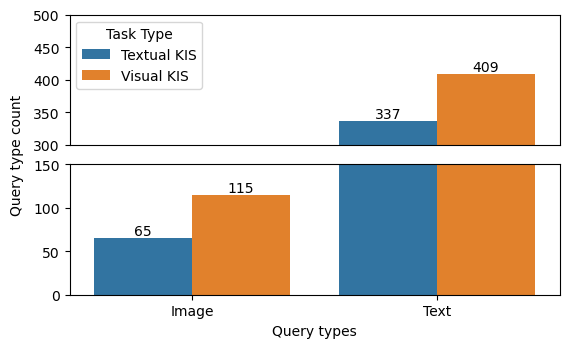

In [31]:
textual_values = vt_counts.loc[vt_counts.index.get_level_values('task_type') == "textual", "value"].tolist()
visual_values = vt_counts.loc[vt_counts.index.get_level_values('task_type') == "visual", "value"].tolist()

barplot_df = pd.DataFrame({
    'Query Types': ["Image", "Text"],
    'Textual KIS': textual_values,
    'Visual KIS': visual_values
})

#fig, ax1 = plt.subplots(figsize=(7, 6))
tidy = barplot_df.melt(id_vars='Query Types').rename(columns=str.title)
tidy = tidy.rename(columns={"Value": "Query Type Count", "Variable": "Task Type", "Query Types": "Query types"})

f, (ax1, ax2) = plt.subplots(ncols=1, nrows=2,
                             sharex=True, figsize=(7, 4))

# we want the "Test" to appear on the x axis as individual parameters
# "Latency in ms" should be what is shown on the y axis as a value
# hue should be the "Experiment Setup"
# this will result three ticks on the x axis with X1...X3 and each with three bars for T1...T3
# (you could turn this around if you need to, depending on what kind of data you want to show)
ax1 = sns.barplot(x='Query types', y='Query Type Count', hue='Task Type', data=tidy, ax=ax1)

# we basically do the same thing again for the second plot
ax2 = sns.barplot(x='Query types', y='Query Type Count', hue='Task Type', data=tidy, ax=ax2)

# here is the fun part: setting the limits for the individual y axis
# the upper part (ax1) should show only values from 250 to 400
# the lower part (ax2) should only show 0 to 150
# you can define your own limits, but the range (150) should be the same so scale is the same across both plots
# it could be possible to use a different range and then adjust plot height but who knows how that works
ax1.set_ylim(300, 500)
ax2.set_ylim(0, 150)

# the upper part does not need its own x axis as it shares one with the lower part
ax1.get_xaxis().set_visible(False)

# by default, each part will get its own "Latency in ms" label, but we want to set a common for the whole figure
# first, remove the y label for both subplots
ax1.set_ylabel("")
ax2.set_ylabel("")
# then, set a new label on the plot (basically just a piece of text) and move it to where it makes sense (requires trial and error)
f.text(0.065, 0.5, "Query type count", va="center", rotation="vertical")

# by default, seaborn also gives each subplot its own legend, which makes no sense at all
# soe remove both default legends first
#ax1.get_legend().remove()
ax2.get_legend().remove()
# then create a new legend and put it to the side of the figure (also requires trial and error)
#ax2.legend(loc=(1.025, 0.5), title="Design")

# let's put some ticks on the top of the upper part and bottom of the lower part for style
ax1.xaxis.tick_top()
ax2.xaxis.tick_bottom()

# finally, adjust everything a bit to make it prettier (this just moves everything, best to try and iterate)
f.subplots_adjust(left=0.15, right=0.85, bottom=0.15, top=0.85, hspace=0.15)

for container in ax1.containers:
    ax1.bar_label(container)
for container in ax2.containers:
    ax2.bar_label(container)

plt.savefig(f'./query_type_vs_task_type.pdf', format='pdf', bbox_inches="tight")
plt.show()


### General per-team statistics from text queries:

In [32]:
medianStats = dataset.groupby(["team","QT"])[["QueryWords","QueryLen","rank_shot_margin_0","rank_shot_margin_5","rank_video"]].median()
medianStats

QueryWords  QueryLen  rank_shot_margin_0  \
team       QT                                                
CVHunter   Image        -1.0      -1.0              2000.0   
           Text          8.0      46.0               887.0   
VISIONE    Image        -1.0      -1.0                92.0   
           Text         14.0      74.0               331.0   
Verge      Image        -1.0      -1.0              2000.0   
           Text          5.0      28.0               877.0   
vibro      Image        -1.0      -1.0               418.5   
           Text          7.0      42.0               414.0   
vitrivr-VR Text          6.0      32.0              2000.0   

                  rank_shot_margin_5  rank_video  
team       QT                                     
CVHunter   Image               586.0       297.5  
           Text                855.0       318.0  
VISIONE    Image                92.0        92.0  
           Text                258.0       144.0  
Verge      Image              2000.0      2000.0  
           Text                701.0       275.0  
vibro      Image               359.0       119.0  
           Text                276.0        75.0  
vitrivr-VR Text               2000.0       144.5

In [33]:
textData = dataset.loc[dataset["QT"]=="Text"]
meanQueryStats = textData.groupby("team")[["QueryWords","QueryLen"]].mean()
meanQueryStats["QT"] = "Text"
meanQueryStats = meanQueryStats.set_index("QT", append=True)
meanQueryStats

,,QueryWords,QueryLen
team,QT,,
CVHunter,Text,9.333333,52.646048
VISIONE,Text,16.118343,84.065089
Verge,Text,5.000000,28.165468
vibro,Text,8.310345,44.333333
vitrivr-VR,Text,6.616667,33.933333


# Efectivity of text queries in general per team
- "topX" depict a percentage of queries, where the correct object was within top-x results
- ">1000" depict a percentage of queries whose results was worse than top-1000
### Finding correct scene

In [34]:
restrData = dataset
tot = restrData.groupby(["team","QT"])["rank_shot_margin_0"].count()
out_of_bound = restrData.loc[restrData.rank_shot_margin_0 > unknownRankLimit].groupby(["team","QT"]).count()["rank_shot_margin_0"]
top5 = restrData.loc[restrData.rank_shot_margin_0 < 5].groupby(["team","QT"]).count()["rank_shot_margin_0"]
top10 = restrData.loc[restrData.rank_shot_margin_0 < 10].groupby(["team","QT"]).count()["rank_shot_margin_0"]
top20 = restrData.loc[restrData.rank_shot_margin_0 < 20].groupby(["team","QT"]).count()["rank_shot_margin_0"]
top50 = restrData.loc[restrData.rank_shot_margin_0 < 50].groupby(["team","QT"]).count()["rank_shot_margin_0"]
top100 = restrData.loc[restrData.rank_shot_margin_0 < 100].groupby(["team","QT"]).count()["rank_shot_margin_0"]
top200 = restrData.loc[restrData.rank_shot_margin_0 < 200].groupby(["team","QT"]).count()["rank_shot_margin_0"]
top500 = restrData.loc[restrData.rank_shot_margin_0 < 500].groupby(["team","QT"]).count()["rank_shot_margin_0"]

topkRes = pd.DataFrame({"Total Queries":tot,
                        "Words per query":medianStats["QueryWords"],
                        "Query length":medianStats["QueryLen"],
                        "top5":(top5/tot*100).round(1),
                        "top10":(top10/tot*100).round(1),
                        "top20":(top20/tot*100).round(1),
                        "top50":(top50/tot*100).round(1),
                        "top100":(top100/tot*100).round(1),
                        "top200":(top200/tot*100).round(1),
                        "top500":(top500/tot*100).round(1),
                        ">1000":(out_of_bound/tot*100).round(1)}).fillna(0)
resTab1 = topkRes.loc[((topkRes["Total Queries"]>=10)&(topkRes.index.get_level_values('QT')!="None"))]

# in the end we want mean stats
resTab1["Words per query"] = meanQueryStats["QueryWords"]
resTab1["Query length"] = meanQueryStats["QueryLen"]
resTab1

C:\Users\Neiko\AppData\Local\Temp\ipykernel_4044\1113860870.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  resTab1["Words per query"] = meanQueryStats["QueryWords"]
C:\Users\Neiko\AppData\Local\Temp\ipykernel_4044\1113860870.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  resTab1["Query length"] = meanQueryStats["QueryLen"]


Total Queries  Words per query  Query length  top5  top10  \
team       QT                                                                 
CVHunter   Image             84              NaN           NaN   4.8    4.8   
           Text             291         9.333333     52.646048   3.8   10.3   
VISIONE    Text             169        16.118343     84.065089   8.9   10.7   
Verge      Image             12              NaN           NaN   0.0    8.3   
           Text             139         5.000000     28.165468   0.7    0.7   
vibro      Image             80              NaN           NaN   2.5    3.8   
           Text              87         8.310345     44.333333   8.0   11.5   
vitrivr-VR Text              60         6.616667     33.933333   3.3   10.0   

                  top20  top50  top100  top200  top500  >1000  
team       QT                                                  
CVHunter   Image    8.3   13.1    20.2    25.0    39.3   51.2  
           Text    11.7   14.1    19.6    28.9    41.2   47.4  
VISIONE    Text    16.6   25.4    31.4    41.4    55.0   37.3  
Verge      Image    8.3    8.3    16.7    16.7    25.0   58.3  
           Text     1.4    2.9     4.3    27.3    34.5   47.5  
vibro      Image   11.2   23.8    31.2    36.2    53.8   38.8  
           Text    19.5   28.7    33.3    39.1    50.6   32.2  
vitrivr-VR Text    13.3   15.0    16.7    25.0    25.0   63.3

## Finding correct scene with slightly larger margins (+5sec)

In [36]:
tot = restrData.groupby(["team","QT"])["rank_shot_margin_0"].count()
out_of_bound = restrData.loc[restrData.rank_shot_margin_5 > unknownRankLimit].groupby(["team","QT"]).count()["rank_shot_margin_5"]
top5 = restrData.loc[restrData.rank_shot_margin_5 < 5].groupby(["team","QT"]).count()["rank_shot_margin_5"]
top10 = restrData.loc[restrData.rank_shot_margin_5 < 10].groupby(["team","QT"]).count()["rank_shot_margin_5"]
top20 = restrData.loc[restrData.rank_shot_margin_5 < 20].groupby(["team","QT"]).count()["rank_shot_margin_5"]
top50 = restrData.loc[restrData.rank_shot_margin_5 < 50].groupby(["team","QT"]).count()["rank_shot_margin_5"]
top100 = restrData.loc[restrData.rank_shot_margin_5 < 100].groupby(["team","QT"]).count()["rank_shot_margin_5"]
top200 = restrData.loc[restrData.rank_shot_margin_5 < 200].groupby(["team","QT"]).count()["rank_shot_margin_5"]
top500 = restrData.loc[restrData.rank_shot_margin_5 < 500].groupby(["team","QT"]).count()["rank_shot_margin_5"]

topkRes = pd.DataFrame({"Total Queries":tot,
                        "Words per query":medianStats["QueryWords"],
                        "Query length":medianStats["QueryLen"],
                        "top5":(top5/tot*100).round(1),
                        "top10":(top10/tot*100).round(1),
                        "top20":(top20/tot*100).round(1),
                        "top50":(top50/tot*100).round(1),
                        "top100":(top100/tot*100).round(1),
                        "top200":(top200/tot*100).round(1),
                        "top500":(top500/tot*100).round(1),
                        ">1000":(out_of_bound/tot*100).round(1)}).fillna(0)
topkRes.loc[((topkRes["Total Queries"]>=10)&(topkRes.index.get_level_values('QT')!="None"))]

Total Queries  Words per query  Query length  top5  top10  \
team       QT                                                                 
CVHunter   Image             84             -1.0          -1.0   6.0    6.0   
           Text             291              8.0          46.0   4.5   11.0   
VISIONE    Text             169             14.0          74.0   9.5   10.7   
Verge      Image             12             -1.0          -1.0   0.0    8.3   
           Text             139              5.0          28.0   0.7    0.7   
vibro      Image             80             -1.0          -1.0   2.5    3.8   
           Text              87              7.0          42.0   8.0   12.6   
vitrivr-VR Text              60              6.0          32.0   3.3   10.0   

                  top20  top50  top100  top200  top500  >1000  
team       QT                                                  
CVHunter   Image    9.5   14.3    23.8    31.0    46.4   45.2  
           Text    11.7   14.1    19.6    30.9    44.0   46.7  
VISIONE    Text    16.6   25.4    32.0    45.6    59.8   31.4  
Verge      Image    8.3    8.3    16.7    16.7    25.0   58.3  
           Text     6.5    9.4    12.9    36.7    44.6   42.4  
vibro      Image   11.2   26.2    33.8    40.0    58.8   32.5  
           Text    24.1   36.8    42.5    44.8    57.5   21.8  
vitrivr-VR Text    13.3   15.0    16.7    25.0    25.0   63.3

## Finding correct video

In [37]:
tot = restrData.groupby(["team","QT"])["rank_shot_margin_0"].count()
out_of_bound = restrData.loc[restrData.rank_video > unknownRankLimit].groupby(["team","QT"]).count()["rank_video"]
top5 = restrData.loc[restrData.rank_video < 5].groupby(["team","QT"]).count()["rank_video"]
top10 = restrData.loc[restrData.rank_video < 10].groupby(["team","QT"]).count()["rank_video"]
top20 = restrData.loc[restrData.rank_video < 20].groupby(["team","QT"]).count()["rank_video"]
top50 = restrData.loc[restrData.rank_video < 50].groupby(["team","QT"]).count()["rank_video"]
top100 = restrData.loc[restrData.rank_video < 100].groupby(["team","QT"]).count()["rank_video"]
top200 = restrData.loc[restrData.rank_video < 200].groupby(["team","QT"]).count()["rank_video"]
top500 = restrData.loc[restrData.rank_video < 500].groupby(["team","QT"]).count()["rank_video"]

topkRes = pd.DataFrame({"Total Queries":tot,
                        "Words per query":medianStats["QueryWords"],
                        "Query length":medianStats["QueryLen"],
                        "top5":(top5/tot*100).round(1),
                        "top10":(top10/tot*100).round(1),
                        "top20":(top20/tot*100).round(1),
                        "top50":(top50/tot*100).round(1),
                        "top100":(top100/tot*100).round(1),
                        "top200":(top200/tot*100).round(1),
                        "top500":(top500/tot*100).round(1),
                        ">1000":(out_of_bound/tot*100).round(1)}).fillna(0)
topkRes.loc[((topkRes["Total Queries"]>=10)&(topkRes.index.get_level_values('QT')!="None"))]

Total Queries  Words per query  Query length  top5  top10  \
team       QT                                                                 
CVHunter   Image             84             -1.0          -1.0  11.9   11.9   
           Text             291              8.0          46.0   5.2   13.7   
VISIONE    Text             169             14.0          74.0  11.8   16.0   
Verge      Image             12             -1.0          -1.0   0.0    8.3   
           Text             139              5.0          28.0   3.6    4.3   
vibro      Image             80             -1.0          -1.0  12.5   18.8   
           Text              87              7.0          42.0  19.5   24.1   
vitrivr-VR Text              60              6.0          32.0  15.0   18.3   

                  top20  top50  top100  top200  top500  >1000  
team       QT                                                  
CVHunter   Image   19.0   20.2    27.4    40.5    60.7   33.3  
           Text    17.2   20.6    26.8    41.6    56.7   35.4  
VISIONE    Text    21.3   34.9    43.2    56.8    67.5   27.2  
Verge      Image    8.3    8.3    16.7    16.7    33.3   58.3  
           Text    14.4   20.1    25.2    46.8    59.7   28.1  
vibro      Image   23.8   35.0    46.2    66.2    78.8   10.0  
           Text    34.5   46.0    52.9    62.1    74.7   11.5  
vitrivr-VR Text    23.3   35.0    45.0    56.7    65.0   21.7

## TODO Observations:

## old Observations:
- vitrivr and vitrivr-VR had clearly inferior search/retrieval model (CLIP vs. not CLIP)
  - may be also due to the users, but I personally doubt it and rather blaim the retrieval model
- most of the teams got other query type results inferior as compared to the text queries
    - one notable exception is CVHunter, where IMAGE queries outperformed text queries for most top-k variants (true both for scenes and videos

As for the text queries:
- apart from both vitrivr, teams are quite close to each other, nonetheless:
  - VERGE good at small top-k, vibro rather the opposite
  - CVHunter largest share of beyond threshold results (">1000") except for vitrivr and vitrivr-VR
- VISIONE in general created lagest queries (QueryWords, QueryLen) as well as second most queries (after vitrivr) - but it may be biased by time to solve task (or they were just quicker to construct queries) - hard to set a righteous criteria (varying query lying intensity throughout the search process)

# Ranking vs. Query length and Query words

In [38]:
textDataWithLength = textData.loc[textData.QueryLen > -1]
textDataWithLength.shape

(746, 21)

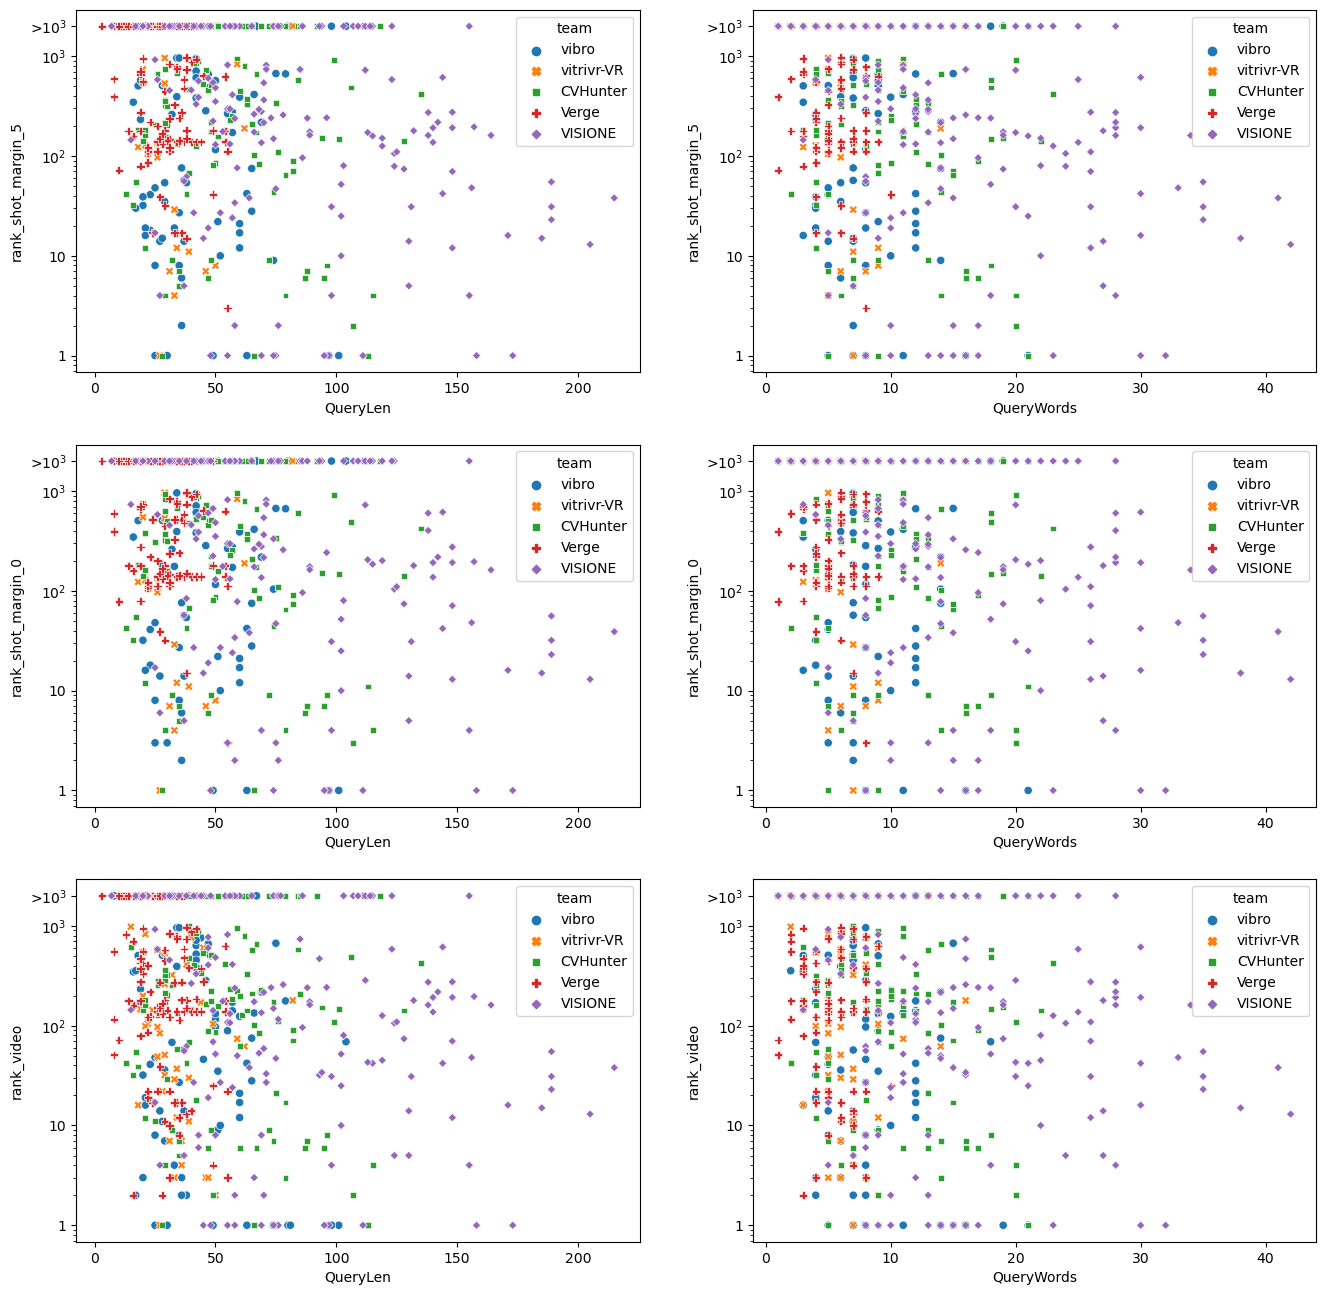

In [39]:
lenParam = ["QueryLen","QueryWords"]
resParam = ["rank_shot_margin_5","rank_shot_margin_0","rank_video"]

fig,ax = plt.subplots(3,2,figsize=(16,16))

for j,lenPar in enumerate(lenParam):
    for i,resPar in enumerate(resParam):
    
        sns.scatterplot(data=textDataWithLength,x=lenPar,y=resPar,style="team", hue="team", ax=ax[i,j])
        ax[i,j].set_yscale("log")

        ax[i,j].set_yticks([1,10,100,1000,2000])
        ax[i,j].set_yticklabels([1,10,'10$^2$','10$^3$','>10$^3$'])


- Really, not much to see, unfortunatelly. 
  - There is (very mild) negative correlation between rank and query length and #words
  - The difference rises up a bit when queries with >1000 results are considered, but not much

In [40]:
textDataKnownShotRanking = textDataWithLength.loc[textDataWithLength.rank_shot_margin_0 < unknownRankValue]
textDataUnknownShotRanking = textDataWithLength.loc[textDataWithLength.rank_shot_margin_0 >= unknownRankValue]
textDataKnownShotRanking[["QueryLen","QueryWords","rank_shot_margin_0"]].corr()

,QueryLen,QueryWords,rank_shot_margin_0
QueryLen,1.00000,0.985760,-0.209110
QueryWords,0.98576,1.000000,-0.227616
rank_shot_margin_0,-0.20911,-0.227616,1.000000


## Are there any dependencies between query length and ability to get decent ranks?
- comparing query statistics for ranks <=1000 and >1000

In [41]:
textDataUnknownShotRanking[["QueryLen","QueryWords"]].mean()

QueryLen      45.105105
QueryWords     8.069069
dtype: float64

In [42]:
textDataKnownShotRanking[["QueryLen","QueryWords"]].mean()

QueryLen      58.874092
QueryWords    11.060533
dtype: float64

In [43]:
textData["rankCat"] = ">1000"
textData.loc[(textData.rank_shot_margin_0 <= 1000),"rankCat"] = "1-1000"
#textData.loc[textData.rank_shot_margin_0 <= 10,"rankCat"] = "1-10"
#textData.loc[((textData.rank_shot_margin_0 > 10)&(textData.rank_shot_margin_0 <= 100)),"rankCat"] = "11-100"
#textData.loc[((textData.rank_shot_margin_0 > 100)&(textData.rank_shot_margin_0 <= 1000)),"rankCat"] = "101-1000"

C:\Users\Neiko\AppData\Local\Temp\ipykernel_4044\522766604.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  textData["rankCat"] = ">1000"


<Axes: xlabel='rankCat', ylabel='QueryLen'>

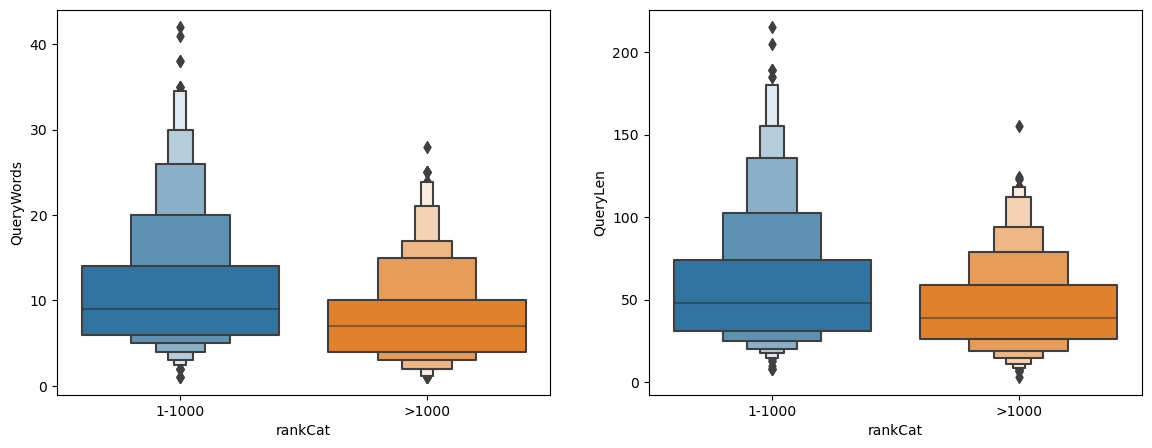

In [44]:
fig,ax = plt.subplots(1,2, figsize=(14,5))
textDataWithLength = textData.loc[textData.QueryLen > -1]
sns.boxenplot(data=textDataWithLength,x="rankCat",y="QueryWords", ax=ax[0])
sns.boxenplot(data=textDataWithLength,x="rankCat",y="QueryLen", ax=ax[1])

In [45]:
from scipy.stats import ttest_ind
print(ttest_ind(textDataWithLength.loc[textDataWithLength.rank_shot_margin_0 <= 1000,"QueryLen"],textDataWithLength.loc[textDataWithLength.rank_shot_margin_0 > 1000,"QueryLen"]))
print(ttest_ind(textDataWithLength.loc[textDataWithLength.rank_shot_margin_0 <= 1000,"QueryWords"],textDataWithLength.loc[textDataWithLength.rank_shot_margin_0 > 1000,"QueryWords"]))

Ttest_indResult(statistic=5.528312021374913, pvalue=4.476661667009118e-08)
Ttest_indResult(statistic=6.215601692429092, pvalue=8.51311753959705e-10)


- The difference between unsuccessful and successful queries is significant w.r.t. query len and query words
    - but it is hardly a comprehensive description (there are large overlaps)

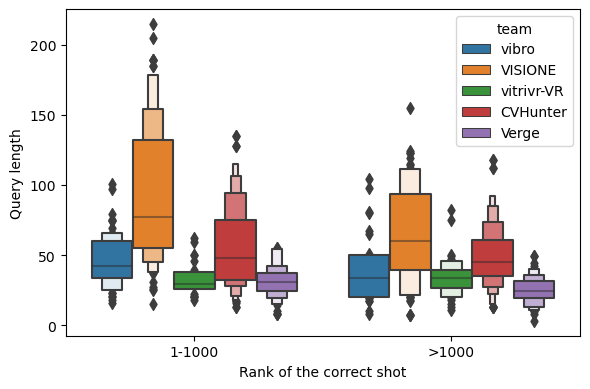

In [46]:
fig,ax = plt.subplots(1,1, figsize=(6,4))
textDataWithLength = textData.loc[textData.QueryLen > -1]
hue_order = team_order

#sns.boxenplot(data=textDataWithLength,x="rankCat",y="QueryWords", hue="team", ax=ax, hue_order = hue_order)
sns.boxenplot(data=textDataWithLength,x="rankCat",y="QueryLen", hue="team", ax=ax, hue_order = hue_order)

#ax.set_xlabel("Rank of the correct shot")
ax.set_xlabel("Rank of the correct shot")
#ax.set_ylabel("Words per query")
ax.set_ylabel("Query length")
plt.tight_layout()
plt.savefig("TextQueryLengthVsRanking.pdf")

- there are very large differences in how individual teams lay queries
    - however, not much of whether they are successful or not depends on their outer characteristics (length)    

In [47]:
for team in textDataWithLength.team.unique():
    print(team)
    print(ttest_ind(textDataWithLength.loc[((textDataWithLength.rank_shot_margin_0 <= 1000)&(textDataWithLength.team==team)),"QueryLen"],textDataWithLength.loc[((textDataWithLength.rank_shot_margin_0 > 1000)&(textDataWithLength.team==team)),"QueryLen"]))
    print(ttest_ind(textDataWithLength.loc[((textDataWithLength.rank_shot_margin_0 <= 1000)&(textDataWithLength.team==team)),"QueryWords"],textDataWithLength.loc[((textDataWithLength.rank_shot_margin_0 > 1000)&(textDataWithLength.team==team)),"QueryWords"]))

vibro
Ttest_indResult(statistic=1.031954178150467, pvalue=0.30502092237358996)
Ttest_indResult(statistic=0.8911205018325179, pvalue=0.3753800575347678)
vitrivr-VR
Ttest_indResult(statistic=-0.2636908700246245, pvalue=0.7929527536343988)
Ttest_indResult(statistic=0.04302936830346377, pvalue=0.9658259181350843)
CVHunter
Ttest_indResult(statistic=2.431584553713989, pvalue=0.015640622766253883)
Ttest_indResult(statistic=3.978931968667395, pvalue=8.759162645811652e-05)
Verge
Ttest_indResult(statistic=3.4006024618753354, pvalue=0.0008812915781446039)
Ttest_indResult(statistic=2.585334254464897, pvalue=0.010773249735972924)
VISIONE
Ttest_indResult(statistic=4.0293073078820285, pvalue=8.481267010044791e-05)
Ttest_indResult(statistic=4.182324713690509, pvalue=4.649811170226759e-05)


In [48]:
for team in textDataWithLength.team.unique():
    print(team)
    print(textDataWithLength.loc[((textDataWithLength.rank_shot_margin_0 <= 1000)&(textDataWithLength.team==team)),"QueryLen"].mean(),textDataWithLength.loc[((textDataWithLength.rank_shot_margin_0 > 1000)&(textDataWithLength.team==team)),"QueryLen"].mean())
    print(textDataWithLength.loc[((textDataWithLength.rank_shot_margin_0 <= 1000)&(textDataWithLength.team==team)),"QueryWords"].mean(),textDataWithLength.loc[((textDataWithLength.rank_shot_margin_0 > 1000)&(textDataWithLength.team==team)),"QueryWords"].mean())

vibro
45.96610169491525 40.892857142857146
8.576271186440678 7.75
vitrivr-VR
33.31818181818182 34.28947368421053
6.636363636363637 6.605263157894737
CVHunter
56.09803921568628 48.81884057971015
10.366013071895425 8.18840579710145
Verge
31.095890410958905 24.924242424242426
5.424657534246576 4.53030303030303
VISIONE
94.5 66.5079365079365
18.245283018867923 12.53968253968254


- the difference is significant especially for vibro and VERGE teams as well as CVHunter w.r.t. QueryWords
- insignificant for vitrivr-VR

### The same for video rank

C:\Users\Neiko\AppData\Local\Temp\ipykernel_4044\2438374289.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  textData["rankCat"] = ">1000"


<Axes: xlabel='rankCat', ylabel='QueryLen'>

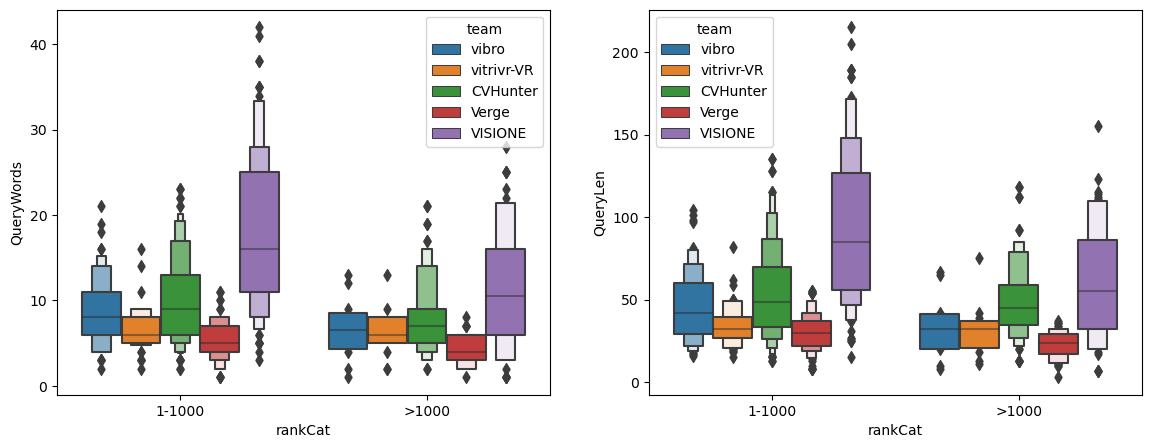

In [49]:
textData["rankCat"] = ">1000"
textData.loc[(textData.rank_video <= 1000),"rankCat"] = "1-1000"
fig,ax = plt.subplots(1,2, figsize=(14,5))
textDataWithLength = textData.loc[textData.QueryLen > -1]
sns.boxenplot(data=textDataWithLength,x="rankCat",y="QueryWords", hue="team", ax=ax[0])
sns.boxenplot(data=textDataWithLength,x="rankCat",y="QueryLen", hue="team", ax=ax[1])

In [50]:
for team in textDataWithLength.team.unique():
    print(team)
    print(ttest_ind(textDataWithLength.loc[((textDataWithLength.rank_video <= 1000)&(textDataWithLength.team==team)),"QueryLen"],textDataWithLength.loc[((textDataWithLength.rank_video > 1000)&(textDataWithLength.team==team)),"QueryLen"]))
    print(ttest_ind(textDataWithLength.loc[((textDataWithLength.rank_video <= 1000)&(textDataWithLength.team==team)),"QueryWords"],textDataWithLength.loc[((textDataWithLength.rank_video > 1000)&(textDataWithLength.team==team)),"QueryWords"]))

vibro
Ttest_indResult(statistic=1.7019674963314133, pvalue=0.09241645961857624)
Ttest_indResult(statistic=1.433285832811022, pvalue=0.15544425708854182)
vitrivr-VR
Ttest_indResult(statistic=0.6200841502565608, pvalue=0.5376311360394421)
Ttest_indResult(statistic=0.4674128867169851, pvalue=0.6419559009510604)
CVHunter
Ttest_indResult(statistic=2.185788103201807, pvalue=0.02963351027182907)
Ttest_indResult(statistic=3.6488075057879614, pvalue=0.00031252202192129564)
Verge
Ttest_indResult(statistic=3.7298894109197813, pvalue=0.0002796095547850117)
Ttest_indResult(statistic=2.7915582939214696, pvalue=0.0059952083998653935)
VISIONE
Ttest_indResult(statistic=4.203420592885392, pvalue=4.274633670951265e-05)
Ttest_indResult(statistic=4.1582834922158955, pvalue=5.1157731798617335e-05)


- For vibro and VERGE, out of range queries w.r.t. both videos and shots had significantly shorter queries w.r.t. both lengths and number of words in them

In [51]:
textualMaxTime = 420000
visualMaxTime = 300000
dataset.loc[((dataset.correct_submission_time_ms.isna())&(dataset.task_type=="textual")),"correct_submission_time_ms"] = textualMaxTime
dataset.loc[((dataset.correct_submission_time_ms.isna())&(dataset.task_type=="visual")),"correct_submission_time_ms"] = visualMaxTime

In [52]:
"""boundaries = [0,60,120,180,240,300,360,420]
boundaries = [b*1000 for b in boundaries]
valid_bins = []
dataset["hist_bin"] = 0

for b in boundaries:
    
    if b > 0:
        # checking whether the team was available throughout the whole period of the bin
        dataset["valid_"+str(b-60*1000)] = (dataset["correct_submission_time_ms"]>=b)
        valid_bins.append("valid_"+str(b-60*1000))
    dataset.loc[dataset.elapsed_since_task_start_ms >= b, "hist_bin"] = b
    
dataset.tail()"""

'boundaries = [0,60,120,180,240,300,360,420]\nboundaries = [b*1000 for b in boundaries]\nvalid_bins = []\ndataset["hist_bin"] = 0\n\nfor b in boundaries:\n    \n    if b > 0:\n        # checking whether the team was available throughout the whole period of the bin\n        dataset["valid_"+str(b-60*1000)] = (dataset["correct_submission_time_ms"]>=b)\n        valid_bins.append("valid_"+str(b-60*1000))\n    dataset.loc[dataset.elapsed_since_task_start_ms >= b, "hist_bin"] = b\n    \ndataset.tail()'

In [53]:
boundaries = [0,60,120,180,240,300,360,420]
boundaries = [b*1000 for b in boundaries]
valid_bins = []
dataset["hist_bin"] = 0

for b in boundaries:
    
    if b > 0:
        # checking whether the team was available throughout the whole period of the bin
        dataset["valid_"+str(b-60*1000)] = (dataset["correct_submission_time_ms"]>=b)
        valid_bins.append("valid_"+str(b-60*1000))
    dataset.loc[dataset.elapsed_since_task_start_ms >= b, "hist_bin"] = b
    
dataset.tail()

,level_0,index,task,team,user,timestamp,elapsed_since_task_start_ms,correct_submission_time_ms,rank_video,rank_shot_margin_0,...,QueryLen,QueryWords,hist_bin,valid_0,valid_60000,valid_120000,valid_180000,valid_240000,valid_300000,valid_360000
232,232,232,vbs23-kis-v6,VISIONE,1,1673279119957,232848,300000.0,34.0,2000.0,...,94,16,180000,True,True,True,True,True,False,False
234,234,234,vbs23-kis-v6,VISIONE,1,1673279120164,233055,300000.0,34.0,2000.0,...,94,16,180000,True,True,True,True,True,False,False
236,236,236,vbs23-kis-v6,VISIONE,1,1673279168219,281110,300000.0,469.0,2000.0,...,93,16,240000,True,True,True,True,True,False,False
238,238,238,vbs23-kis-v6,VISIONE,1,1673279178841,291732,300000.0,107.0,297.0,...,56,10,240000,True,True,True,True,True,False,False
239,239,239,vbs23-kis-v6,VISIONE,1,1673279185042,297933,300000.0,142.0,224.0,...,49,9,240000,True,True,True,True,True,False,False


## Intensity of laying queries over time
- 30 second intervals
- normalized by the volume of still compeeting teams+task within that time window

In [54]:
#remove data that are from the histogram bins where the team submitted (i.e. did not continue throughout the bin duration)
validRestrData = dataset.copy()
print(validRestrData.shape)
for vb in valid_bins:
    validRestrData = validRestrData.loc[~((validRestrData[vb]==False)&(validRestrData["hist_bin"]>=int(vb.replace("valid_","")) ))]
print(validRestrData.shape)

(926, 29)
(696, 29)


In [55]:
bin_divisors = validRestrData.groupby(["team","task"])[valid_bins].max().sum()
bin_divisors.index = bin_divisors.index.str.replace("valid_","").astype(int)

In [56]:
hist_counts = validRestrData.groupby("hist_bin")["team"].count()

<Axes: xlabel='hist_bin'>

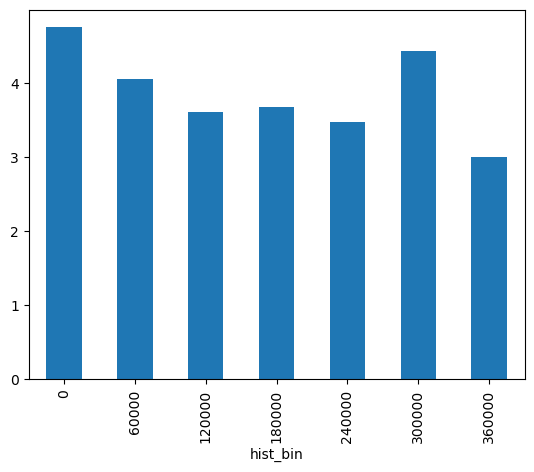

In [57]:
(hist_counts / bin_divisors).plot.bar()
#TODO make the graph publication-ready (descriptions etc.)

In [58]:
(hist_counts / bin_divisors)

hist_bin
0         4.754386
60000     4.057143
120000    3.615385
180000    3.681818
240000    3.470588
300000    4.428571
360000    3.000000
dtype: float64

### Observations:
- there are no huge differences, but still, the volume of queries per time tends to decrease a bit in the later stages of the search
- perhaps users already depleated ways to reformulate and focus more on the browsing
- the initial lower values are probably caused by the information processing gap (watching the scene, reading the description)

## Per-team querying density

In [59]:
#total availabe time to ask queries per team
totTime = dataset.groupby(["team","task"])[["correct_submission_time_ms"]].min().reset_index().groupby("team")["correct_submission_time_ms"].sum()
totTime

team
CVHunter      3247500.0
VISIONE       2205469.0
Verge         3538370.0
vibro         1896544.0
vitrivr-VR    1869350.0
Name: correct_submission_time_ms, dtype: float64

In [60]:
#per-team query density
# queryCount = dataset.groupby("team")["task"].count()
queryCount = dataset.groupby(["team", "timestamp"])['task'].count().reset_index()
queryCount = queryCount.groupby(["team"]).count()
queryCount = queryCount['task']
queryCount

team
CVHunter      375
VISIONE       171
Verge         133
vibro         160
vitrivr-VR     60
Name: task, dtype: int64

In [61]:
queryPerMinute = queryCount/totTime*1000*60
queryPerMinute

team
CVHunter      6.928406
VISIONE       4.652072
Verge         2.255276
vibro         5.061839
vitrivr-VR    1.925803
dtype: float64

In [62]:
qpmdf = pd.DataFrame({"QPM":queryPerMinute})
qpmdf["QT"] = "Text"
qpmdf = qpmdf.set_index("QT", append=True)

In [63]:
teams

['HTW', 'VISIONE', 'VIREO', 'vitrivr-VR', 'CVHunter', 'vitrivr', 'Verge']

In [64]:
resTab1["Query per Minute"] = qpmdf["QPM"]
resTab1 = resTab1.loc[team_order, ['Text','Image'], :]
print(resTab1[["Query per Minute","Words per query","Query length","top10","top20","top50","top100","top200",">1000"]].round(2).to_latex())
#print(resTab1[["Query per Minute","Words per query","Query length","top10","top20","top50","top100","top200",">1000"]].to_latex())

\begin{tabular}{llrrrrrrrrr}
\toprule
      &       &  Query per Minute &  Words per query &  Query length &  top10 &  top20 &  top50 &  top100 &  top200 &  >1000 \\
team & QT &                   &                  &               &        &        &        &         &         &        \\
\midrule
vibro & Text &              5.06 &             8.31 &         44.33 &   11.5 &   19.5 &   28.7 &    33.3 &    39.1 &   32.2 \\
      & Image &               NaN &              NaN &           NaN &    3.8 &   11.2 &   23.8 &    31.2 &    36.2 &   38.8 \\
VISIONE & Text &              4.65 &            16.12 &         84.07 &   10.7 &   16.6 &   25.4 &    31.4 &    41.4 &   37.3 \\
vitrivr-VR & Text &              1.93 &             6.62 &         33.93 &   10.0 &   13.3 &   15.0 &    16.7 &    25.0 &   63.3 \\
CVHunter & Text &              6.93 &             9.33 &         52.65 &   10.3 &   11.7 &   14.1 &    19.6 &    28.9 &   47.4 \\
      & Image &               NaN &              NaN & 

C:\Users\Neiko\AppData\Local\Temp\ipykernel_4044\2534570869.py:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(resTab1[["Query per Minute","Words per query","Query length","top10","top20","top50","top100","top200",">1000"]].round(2).to_latex())


In [65]:
resTab1[["Query per Minute","Words per query","Query length","top10","top20","top50","top100","top200",">1000"]].round(2)

Query per Minute  Words per query  Query length  top10  \
team       QT                                                              
vibro      Text               5.06             8.31         44.33   11.5   
           Image               NaN              NaN           NaN    3.8   
VISIONE    Text               4.65            16.12         84.07   10.7   
vitrivr-VR Text               1.93             6.62         33.93   10.0   
CVHunter   Text               6.93             9.33         52.65   10.3   
           Image               NaN              NaN           NaN    4.8   
Verge      Text               2.26             5.00         28.17    0.7   
           Image               NaN              NaN           NaN    8.3   

                  top20  top50  top100  top200  >1000  
team       QT                                          
vibro      Text    19.5   28.7    33.3    39.1   32.2  
           Image   11.2   23.8    31.2    36.2   38.8  
VISIONE    Text    16.6   25.4    31.4    41.4   37.3  
vitrivr-VR Text    13.3   15.0    16.7    25.0   63.3  
CVHunter   Text    11.7   14.1    19.6    28.9   47.4  
           Image    8.3   13.1    20.2    25.0   51.2  
Verge      Text     1.4    2.9     4.3    27.3   47.5  
           Image    8.3    8.3    16.7    16.7   58.3

### Observations:
- vitrivr-VR is notably slower in query construction (or just spent much more time in browsing - is it VR to blame?)
- VISIONE and vibro depended more heavily on querying

In [66]:
queryCount = dataset.groupby(["team","user"])["task"].count()
queryCount

team        user
CVHunter    0       179
            1       196
VISIONE     0        50
            1       123
Verge       0       151
vibro       0        76
            1        91
vitrivr-VR  0        37
            1        23
Name: task, dtype: int64

- does not look like so notable differences among individual users... skip for now

## Initial response time
- how quickly did individual teams managed to ask their first query?

In [67]:
initTime = (dataset.groupby(["team","task","user","task_type"])[["elapsed_since_task_start_ms"]].min()/1000).reset_index()

In [68]:
initTime.groupby(["team","task_type"]).mean()["elapsed_since_task_start_ms"]

C:\Users\Neiko\AppData\Local\Temp\ipykernel_4044\2926304620.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  initTime.groupby(["team","task_type"]).mean()["elapsed_since_task_start_ms"]


team        task_type
CVHunter    textual      24.906286
            visual       14.585625
VISIONE     textual      20.116857
            visual       15.461708
Verge       textual      33.344429
            visual       31.008889
vibro       textual      22.631571
            visual       17.324000
vitrivr-VR  textual      51.527333
            visual       41.811190
Name: elapsed_since_task_start_ms, dtype: float64

In [69]:
initTime.groupby(["team","task_type"]).median()["elapsed_since_task_start_ms"]

C:\Users\Neiko\AppData\Local\Temp\ipykernel_4044\3133183519.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  initTime.groupby(["team","task_type"]).median()["elapsed_since_task_start_ms"]


team        task_type
CVHunter    textual      22.1820
            visual       13.9690
VISIONE     textual      19.2780
            visual       15.3995
Verge       textual      32.7360
            visual       31.4920
vibro       textual      23.9110
            visual       16.1450
vitrivr-VR  textual      44.5090
            visual       36.5190
Name: elapsed_since_task_start_ms, dtype: float64

In [70]:
initTime.groupby(["team","task_type"]).min()["elapsed_since_task_start_ms"]

team        task_type
CVHunter    textual      13.617
            visual        8.361
VISIONE     textual      13.273
            visual        8.302
Verge       textual      26.051
            visual       14.814
vibro       textual       6.245
            visual        6.343
vitrivr-VR  textual      32.105
            visual       18.476
Name: elapsed_since_task_start_ms, dtype: float64

In [71]:
dataset.loc[((dataset.team == "CVHunter") & (dataset.task=="vbs22-kis-t09"))]

,level_0,index,task,team,user,timestamp,elapsed_since_task_start_ms,correct_submission_time_ms,rank_video,rank_shot_margin_0,...,QueryLen,QueryWords,hist_bin,valid_0,valid_60000,valid_120000,valid_180000,valid_240000,valid_300000,valid_360000


In [72]:
initTime.groupby(["task_type"]).mean()["elapsed_since_task_start_ms"]

C:\Users\Neiko\AppData\Local\Temp\ipykernel_4044\3085733443.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  initTime.groupby(["task_type"]).mean()["elapsed_since_task_start_ms"]


task_type
textual    28.350397
visual     22.490461
Name: elapsed_since_task_start_ms, dtype: float64

<Axes: xlabel='team', ylabel='elapsed_since_task_start_ms'>

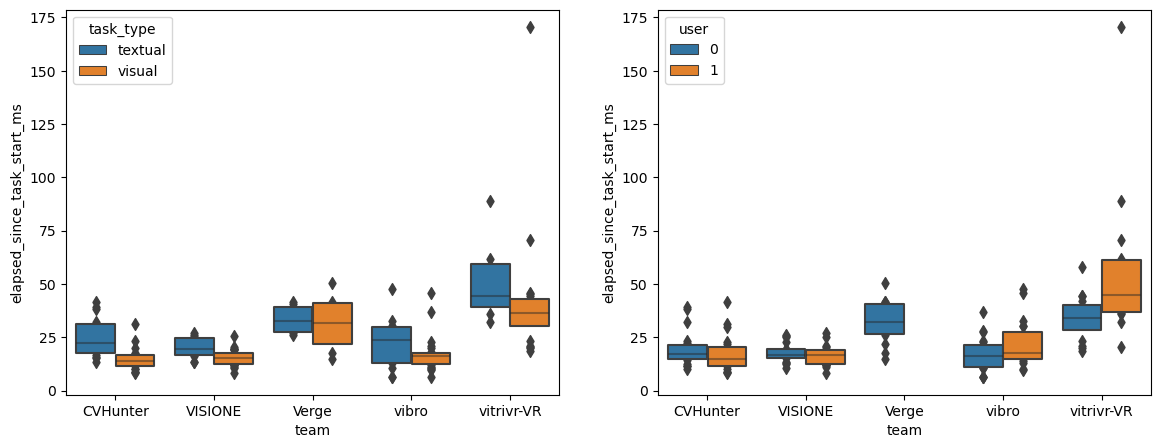

In [73]:
fig,ax = plt.subplots(1,2, figsize=(14,5))
sns.boxenplot(data=initTime,x="team",y="elapsed_since_task_start_ms", hue="task_type", ax=ax[0])
sns.boxenplot(data=initTime,x="team",y="elapsed_since_task_start_ms", hue="user", ax=ax[1])

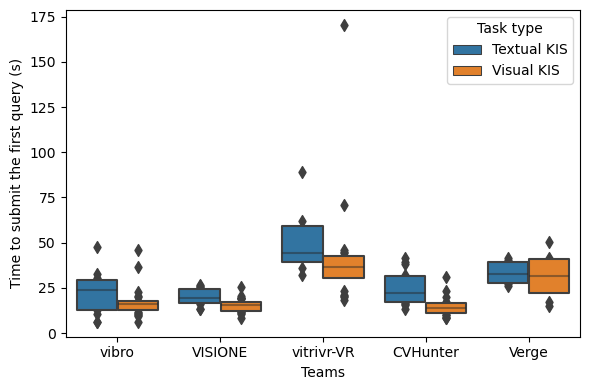

In [74]:
fig,ax = plt.subplots(1,1, figsize=(6,4))
initTime["Task type"] = "Textual KIS"
initTime.loc[initTime.task_type=="visual","Task type"] = "Visual KIS"

sns.boxenplot(data=initTime,x="team",y="elapsed_since_task_start_ms", hue="Task type", ax=ax, order=team_order )

ax.set_xlabel("Teams")
ax.set_ylabel("Time to submit the first query (s)")
plt.tight_layout()
plt.savefig("TimeToFirstQueryPerTeam.pdf")

In [75]:
print(ttest_ind(initTime.loc[initTime.team == "vitrivr-VR","elapsed_since_task_start_ms"],initTime.loc[initTime.team != "vitrivr-VR","elapsed_since_task_start_ms"]))

Ttest_indResult(statistic=8.25957905627412, pvalue=5.521016557216569e-14)


In [76]:
print(ttest_ind(initTime.loc[((initTime.team == "vitrivr")&(initTime["Task type"]=="Textual KIS")),"elapsed_since_task_start_ms"],initTime.loc[((initTime.team == "vitrivr")&(initTime["Task type"]=="Visual KIS")),"elapsed_since_task_start_ms"]))

Ttest_indResult(statistic=nan, pvalue=nan)


- not much difference between task types (a bit surprising, I was expecting longer times for visual tasks)
- vitrivr-VR has considerably & significantly larger times than all other teams (again, blaim VR or more focused on browsing from the beginning?)
- some variance between users, but not quite sure what to get from that...

# How (how much) reformulations help?

In [77]:
ranks = []
lastRank = 0
lastRecord = (0,0,0)
#TODO: only for textual reformulations
sortedData = textData.sort_values(["task","team","user","timestamp"])
for idx, row in sortedData.iterrows():
    record = (row["task"],row["team"],row["user"])
    if record != lastRecord:
        lastRecord = record
        lastRank = 0
    lastRank += 1
    ranks.append(lastRank)

sortedData["QueryRank"] = ranks

#record how long was the interaction for each task and user
querySeriesLen = sortedData.groupby(["task","team","user"])[["QueryRank"]].max()
querySeriesLen.columns = ["MaxQueryRank"]
sortedData = sortedData.join(querySeriesLen, on=["task","team","user"])
sortedData.head()

,level_0,index,task,team,user,timestamp,elapsed_since_task_start_ms,correct_submission_time_ms,rank_video,rank_shot_margin_0,...,value,additionals,is_user_with_correct_submission,task_type,QT,QueryLen,QueryWords,rankCat,QueryRank,MaxQueryRank
753,49,49,vbs23-kis-t1,CVHunter,0,1673260392327,19466,345478.0,18.0,522.0,...,kids in kayaks on a river throwing paddles,NaN,0.0,textual,Text,42,8,1-1000,1,10
754,50,50,vbs23-kis-t1,CVHunter,0,1673260393758,20897,345478.0,18.0,522.0,...,kids in kayaks on a river throwing paddles,NaN,0.0,textual,Text,42,8,1-1000,2,10
761,57,57,vbs23-kis-t1,CVHunter,0,1673260425436,52575,345478.0,185.0,255.0,...,kids in kayaks on a river throwing paddles coloured hoops,NaN,0.0,textual,Text,57,10,1-1000,3,10
762,58,58,vbs23-kis-t1,CVHunter,0,1673260427393,54532,345478.0,185.0,255.0,...,kids in kayaks on a river throwing paddles coloured hoops,NaN,0.0,textual,Text,57,10,1-1000,4,10
765,61,61,vbs23-kis-t1,CVHunter,0,1673260450068,77207,345478.0,89.0,459.0,...,kids in red kayaks on a river throwing paddles,NaN,0.0,textual,Text,47,9,1-1000,5,10


[Text(0, 1, '1'),
 Text(0, 10, '10'),
 Text(0, 100, '10$^2$'),
 Text(0, 1000, '10$^3$'),
 Text(0, 2000, '>10$^3$')]

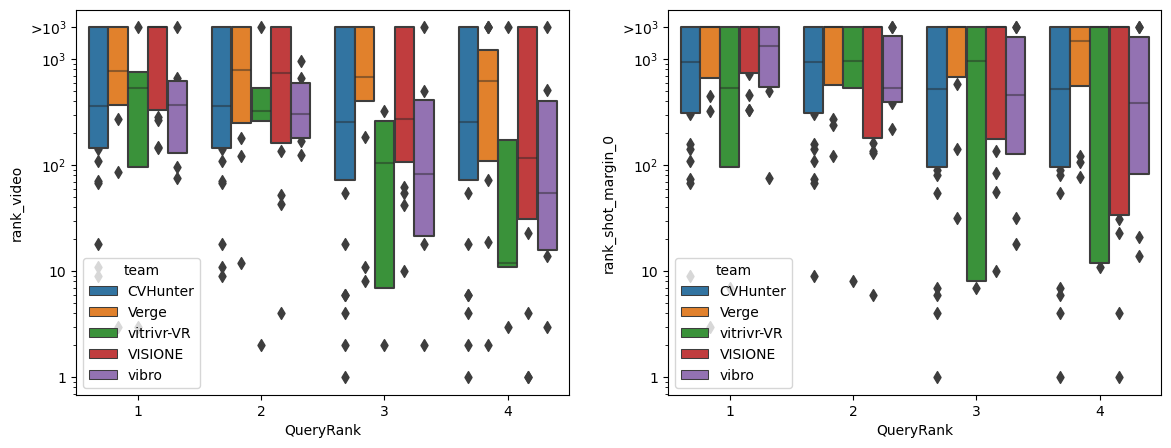

In [78]:
dt = sortedData.loc[((sortedData.QueryRank <= 4)&(sortedData.MaxQueryRank >= 4))]

fig,ax = plt.subplots(1,2, figsize=(14,5))
sns.boxenplot(data=dt,x="QueryRank",y="rank_video", hue="team", ax=ax[0])
sns.boxenplot(data=dt,x="QueryRank",y="rank_shot_margin_0", hue="team", ax=ax[1])

ax[0].set_yscale("log")
ax[0].set_yticks([1,10,100,1000,2000])
ax[0].set_yticklabels([1,10,'10$^2$','10$^3$','>10$^3$'])

ax[1].set_yscale("log")
ax[1].set_yticks([1,10,100,1000,2000])
ax[1].set_yticklabels([1,10,'10$^2$','10$^3$','>10$^3$'])

[Text(0, 1, '1'),
 Text(0, 10, '10'),
 Text(0, 100, '10$^2$'),
 Text(0, 1000, '10$^3$'),
 Text(0, 2000, '>10$^3$')]

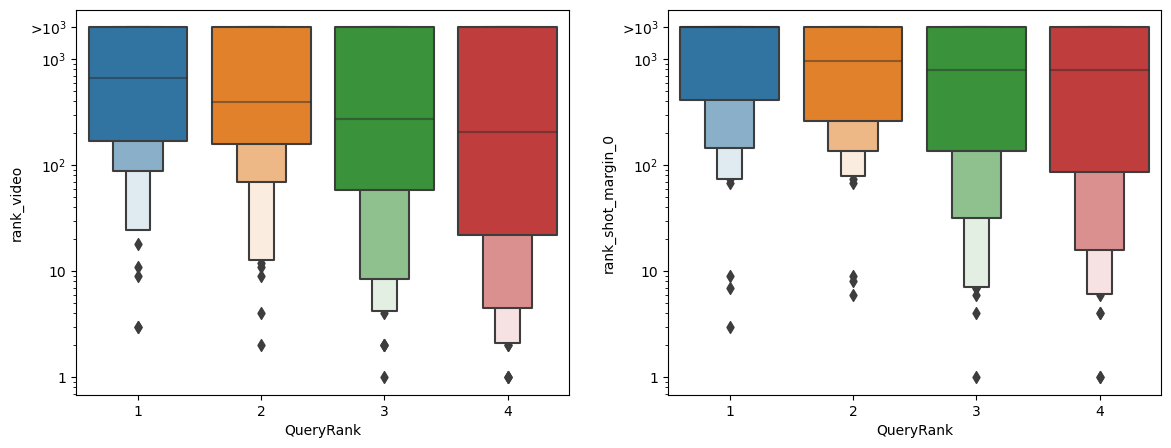

In [79]:
fig,ax = plt.subplots(1,2, figsize=(14,5))
sns.boxenplot(data=dt,x="QueryRank",y="rank_video", ax=ax[0])
sns.boxenplot(data=dt,x="QueryRank",y="rank_shot_margin_0",  ax=ax[1])

ax[0].set_yscale("log")
ax[0].set_yticks([1,10,100,1000,2000])
ax[0].set_yticklabels([1,10,'10$^2$','10$^3$','>10$^3$'])

ax[1].set_yscale("log")
ax[1].set_yticks([1,10,100,1000,2000])
ax[1].set_yticklabels([1,10,'10$^2$','10$^3$','>10$^3$'])

## Observations:
- quite notably, reformulation helps: throughout most of the teams and also in average
- there were multiple cases, when query results were quite good (10 - 10^2), but they were reformulated anyway -> blaim GUI?
- was thinking about directly comparing (previous - next) query ranks, but out-of-range results would make this comparison inconsistent

### The same, but counting query reformulations from the last query backwards 
- i.e., -3 denotes three queries before the last one made by the user for that particular task
- only sessions with 4+ queries were kept

[Text(0, 1, '1'),
 Text(0, 10, '10'),
 Text(0, 100, '10$^2$'),
 Text(0, 1000, '10$^3$'),
 Text(0, 2000, '>10$^3$')]

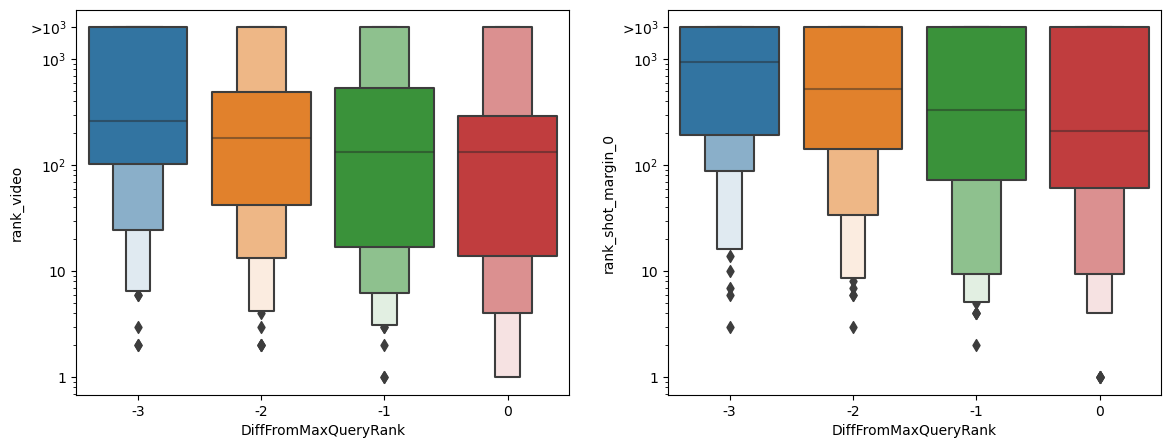

In [80]:
sortedData["DiffFromMaxQueryRank"] = sortedData.QueryRank - sortedData.MaxQueryRank
dt2 = sortedData.loc[((sortedData.DiffFromMaxQueryRank >= -3)&(sortedData.MaxQueryRank > 3))]
fig,ax = plt.subplots(1,2, figsize=(14,5))
sns.boxenplot(data=dt2,x="DiffFromMaxQueryRank",y="rank_video", ax=ax[0])
sns.boxenplot(data=dt2,x="DiffFromMaxQueryRank",y="rank_shot_margin_0",  ax=ax[1])

ax[0].set_yscale("log")
ax[0].set_yticks([1,10,100,1000,2000])
ax[0].set_yticklabels([1,10,'10$^2$','10$^3$','>10$^3$'])

ax[1].set_yscale("log")
ax[1].set_yticks([1,10,100,1000,2000])
ax[1].set_yticklabels([1,10,'10$^2$','10$^3$','>10$^3$'])

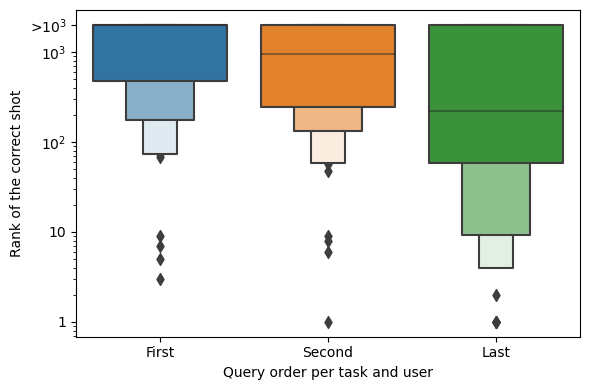

In [81]:
sortedData["RankForViz"] = -1
sortedData.loc[sortedData["QueryRank"]==1,"RankForViz"] = 1
sortedData.loc[sortedData["QueryRank"]==2,"RankForViz"] = 2
#sortedData.loc[sortedData["QueryRank"]==3,"RankForViz"] = 3
sortedData.loc[sortedData["DiffFromMaxQueryRank"]==0,"RankForViz"] = 3

#query series of length at least 4 
dt2 = sortedData.loc[((sortedData.RankForViz !=-1)&(sortedData.MaxQueryRank >= 3))] 
fig,ax = plt.subplots(1,1, figsize=(6,4))

sns.boxenplot(data=dt2,x="RankForViz",y="rank_shot_margin_0",  ax=ax)
#sns.boxenplot(data=dt2,x="RankForViz",y="rank_video", ax=ax[1])


#ax[1].set_yscale("log")
#ax[1].set_yticks([1,10,100,1000,2000])
#ax[1].set_yticklabels([1,10,'10$^2$','10$^3$','>10$^3$'])
#ax[1].set_xticklabels(["First","Second","Last"])
#ax[1].set_xlabel("Query order per task and user")
#ax[1].set_ylabel("Best rank of a shot from the correct video")

ax.set_yscale("log")
ax.set_yticks([1,10,100,1000,2000])
ax.set_yticklabels([1,10,'10$^2$','10$^3$','>10$^3$'])
ax.set_xticklabels(["First","Second","Last"])
ax.set_xlabel("Query order per task and user")
ax.set_ylabel("Rank of the correct shot")

plt.tight_layout()
plt.savefig("QueryReformulation.pdf")


Text(0, 0.5, 'Rank of the correct shot')

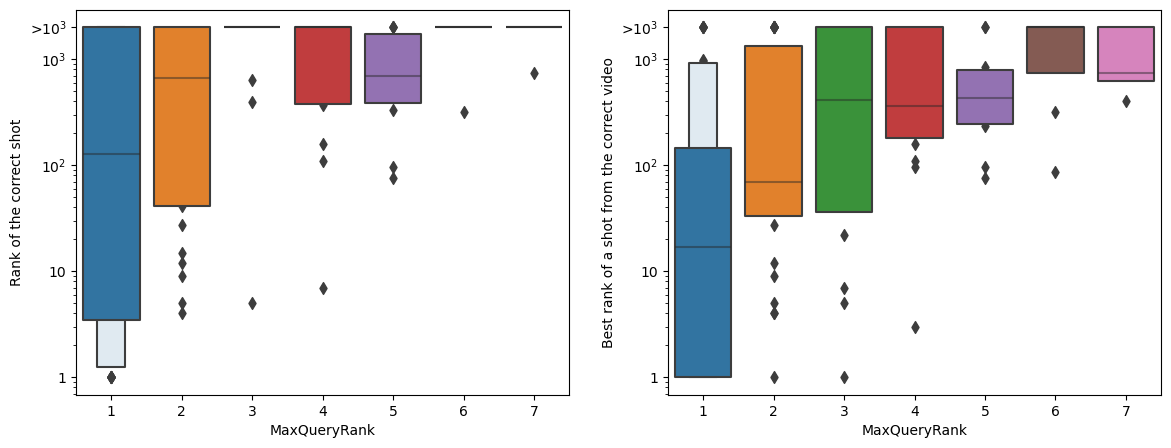

In [82]:
#query series of length at least 4 
dt2 = sortedData.loc[((sortedData.QueryRank == 1)&(sortedData.MaxQueryRank <= 7))] 
fig,ax = plt.subplots(1,2, figsize=(14,5))

sns.boxenplot(data=dt2,x="MaxQueryRank",y="rank_shot_margin_0",  ax=ax[0])
sns.boxenplot(data=dt2,x="MaxQueryRank",y="rank_video", ax=ax[1])


ax[1].set_yscale("log")
ax[1].set_yticks([1,10,100,1000,2000])
ax[1].set_yticklabels([1,10,'10$^2$','10$^3$','>10$^3$'])


ax[1].set_ylabel("Best rank of a shot from the correct video")

ax[0].set_yscale("log")
ax[0].set_yticks([1,10,100,1000,2000])
ax[0].set_yticklabels([1,10,'10$^2$','10$^3$','>10$^3$'])

ax[0].set_ylabel("Rank of the correct shot")



Text(0, 0.5, 'Rank of the correct shot')

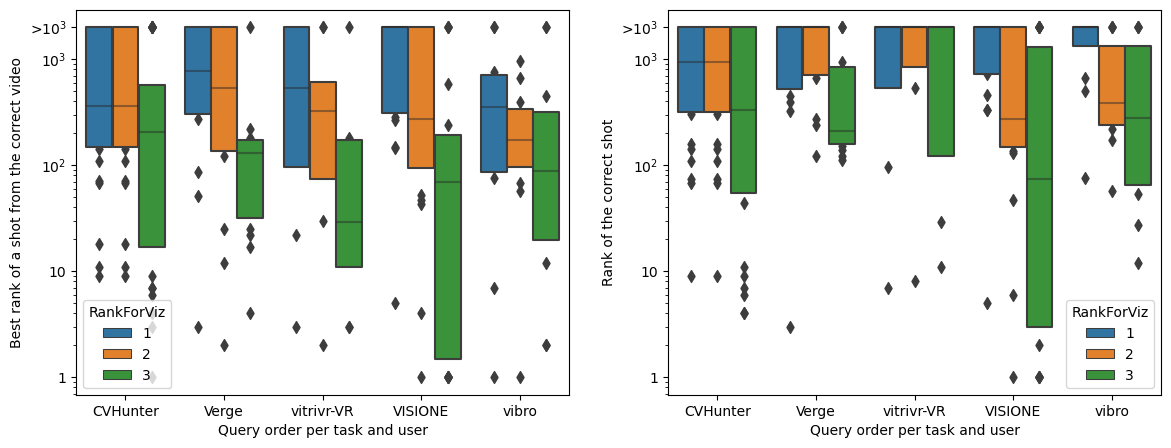

In [83]:

#query series of length at least 4 
dt2 = sortedData.loc[((sortedData.RankForViz !=-1)&(sortedData.MaxQueryRank >= 3))] 
fig,ax = plt.subplots(1,2, figsize=(14,5))

sns.boxenplot(data=dt2, x="team", hue="RankForViz",y="rank_shot_margin_0",  ax=ax[1])
sns.boxenplot(data=dt2, x="team", hue="RankForViz",y="rank_video", ax=ax[0])


ax[0].set_yscale("log")
ax[0].set_yticks([1,10,100,1000,2000])
ax[0].set_yticklabels([1,10,'10$^2$','10$^3$','>10$^3$'])
#ax[0].set_xticklabels(["First","Second","Last"])
ax[0].set_xlabel("Query order per task and user")
ax[0].set_ylabel("Best rank of a shot from the correct video")

ax[1].set_yscale("log")
ax[1].set_yticks([1,10,100,1000,2000])
ax[1].set_yticklabels([1,10,'10$^2$','10$^3$','>10$^3$'])
#ax[1].set_xticklabels(["First","Second","Last"])
ax[1].set_xlabel("Query order per task and user")
ax[1].set_ylabel("Rank of the correct shot")

In [84]:
dt2.groupby(["team","DiffFromMaxQueryRank"])[["rank_video","rank_shot_margin_0"]].median()

rank_video  rank_shot_margin_0
team       DiffFromMaxQueryRank                                
CVHunter   -19                       1427.5              1427.5
           -18                       1427.5              1427.5
           -17                       2000.0              2000.0
           -16                       2000.0              2000.0
           -15                       1071.0              1071.0
...                                     ...                 ...
vitrivr-VR -4                         315.5               315.5
           -3                         534.0               959.0
           -2                         409.0              2000.0
           -1                         338.5              2000.0
            0                          29.0              2000.0

[61 rows x 2 columns]